# Classification task

In [ ]:
from torchvision import datasets

In [ ]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5)]) 

train_dataset = datasets.FashionMNIST('classifier_data', train=True, download=True, transform = transform)
test_dataset  = datasets.FashionMNIST('classifier_data', train=False, download=True, transform = transform)

n_train = int(len(train_dataset))
n_test = int(len(test_dataset))

split_idx = int(0.75*n_train)
train_samples = rand_sampler(list(range(n_train))[:split_idx])
val_samples = rand_sampler(list(range(n_train))[split_idx:])

train_dataloader = DataLoader(train_dataset, sampler = train_samples, batch_size = 128, num_workers = 0)
val_dataloader = DataLoader(train_dataset, sampler = val_samples, batch_size = 128, num_workers = 0)

test_dataloader = DataLoader(test_dataset, batch_size = n_test, shuffle = True, num_workers = 0)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


SAMPLE AT INDEX 1
LABEL: 0


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


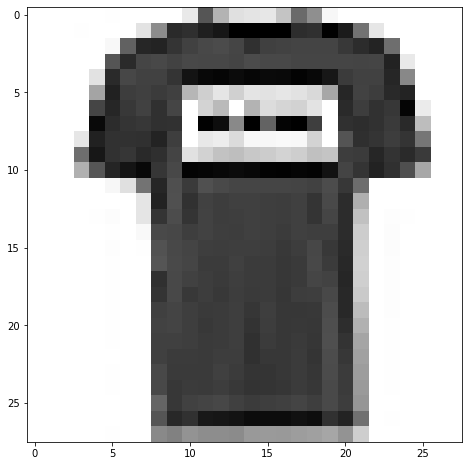

In [ ]:
sample_index = 1
image = train_dataset[sample_index][0].squeeze()
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

img_shape = tuple(image.shape)
no_labels = len(np.unique(train_dataset.train_labels))

In [ ]:
class train_API(nn.Module):
    
#    super(nn.Module).__init__()
    super(nn.Module).train()
    super(nn.Module).zero_grad()
    def train_model(self, device, train_loader, val_loader, num_epochs, loss_fn, optimizer, verbose = True):
        train_loss_log = []
        val_loss_log = []
        for epoch_num in range(num_epochs):
            ### TRAIN
            train_loss= []
            self.train() # Training mode (e.g. enable dropout, batchnorm updates,...)
            for sample_batched in train_loader:
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)

                # Forward pass
                out = self(x_batch)

                # Compute loss
                loss = loss_fn(out, label_batch)

                # Backpropagation
                self.zero_grad()
                loss.backward()

                # Update the weights
                optimizer.step()

                # Save train loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                train_loss.append(loss_batch)

            train_loss = np.mean(train_loss)
            train_loss_log.append(train_loss)

            ### VALIDATION
            val_loss= []
            self.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
            with torch.no_grad(): # Disable gradient tracking
                for sample_batched in val_loader:
                    # Move data to device
                    x_batch = sample_batched[0].to(device)
                    label_batch = sample_batched[1].to(device)

                    # Forward pass
                    out = self(x_batch)

                    # Compute loss
                    loss = loss_fn(out, label_batch)

                    # Save val loss for this batch
                    loss_batch = loss.detach().cpu().numpy()
                    val_loss.append(loss_batch)

                # Save average validation loss
                val_loss = np.mean(val_loss)
                if verbose:
                    print(f"Epoch: {epoch_num} :::::::::: AVERAGE VAL LOSS: {np.mean(val_loss):.5f}", end = '\r')
                val_loss_log.append(val_loss)

        self.train_history = train_loss_log
        self.val_history = val_loss_log


In [ ]:
class CNN2D(nn.Module, train_API):
    super(nn.Module).train()
    super(nn.Module).zero_grad()
    def __init__(self, conv1_size, conv2_size, Nh1, Nh2, N_labels):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super(nn.Module).__init__()

        super(train_API).train_model()
        self.conv1 = nn.Conv2d(1, conv1_size, 5) # 28 to 24(* conv1_size)
        self.conv2 = nn.Conv2d(conv1_size, conv2_size, 5) # 24 to 12, and 12 to 8(*conv2_size)
        self.fc1 = nn.Linear(in_features= conv1_size*4**2, out_features=Nh1) # 8 to 4(*conv2_size), 4 to 4*4*conv2_size
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=N_labels)
                
        print("Network initialized")
        
    def forward(self, x, additional_out=False):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2, stride = 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2, stride = 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.out(x))
        return x
    
    def no_params_conv(self, in_size, kernel, padding, stride):
        """
        Finds no of parameters per channel after every convolution/pooling
        """
        return int((in_size - kernel + 2*padding)/stride + 1)
    
    
#     def train_model(self, device, train_loader, val_loader, num_epochs, loss_fn, optimizer, verbose = True):
#         train_loss_log = []
#         val_loss_log = []
#         for epoch_num in range(num_epochs):
#             ### TRAIN
#             train_loss= []
#             self.train() # Training mode (e.g. enable dropout, batchnorm updates,...)
#             for sample_batched in train_loader:
#                 # Move data to device
#                 x_batch = sample_batched[0].to(device)
#                 label_batch = sample_batched[1].to(device)

#                 # Forward pass
#                 out = self(x_batch)

#                 # Compute loss
#                 loss = loss_fn(out, label_batch)

#                 # Backpropagation
#                 self.zero_grad()
#                 loss.backward()

#                 # Update the weights
#                 optimizer.step()

#                 # Save train loss for this batch
#                 loss_batch = loss.detach().cpu().numpy()
#                 train_loss.append(loss_batch)

#             train_loss = np.mean(train_loss)
#             train_loss_log.append(train_loss)

#             ### VALIDATION
#             val_loss= []
#             self.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
#             with torch.no_grad(): # Disable gradient tracking
#                 for sample_batched in val_loader:
#                     # Move data to device
#                     x_batch = sample_batched[0].to(device)
#                     label_batch = sample_batched[1].to(device)

#                     # Forward pass
#                     out = self(x_batch)

#                     # Compute loss
#                     loss = loss_fn(out, label_batch)

#                     # Save val loss for this batch
#                     loss_batch = loss.detach().cpu().numpy()
#                     val_loss.append(loss_batch)

#                 # Save average validation loss
#                 val_loss = np.mean(val_loss)
#                 if verbose:
#                     print(f"Epoch: {epoch_num} :::::::::: AVERAGE VAL LOSS: {np.mean(val_loss):.5f}", end = '\r')
#                 val_loss_log.append(val_loss)

#         self.train_history = train_loss_log
#         self.val_history = val_loss_log



AttributeError: 'super' object has no attribute 'train'

In [ ]:
CNN_arch = [nn.Conv2d(1, 4, 5),
            nn.Conv2d(4, 6, 5),
            nn.Linear(6*4**2, 12),
            nn.Linear(12, 12),
            nn.Linear(12, 10)]

forward_pass = [{'layer' : CNN_arch[0], 'function' : F.max_pool2d, 'act' : F.relu, 'args' : (2), 'kwargs' : {"stride" : 2}},
                {'layer' : CNN_arch[1], 'function' : F.max_pool2d, 'act' : F.relu, 'args' : (2), 'kwargs' : {"stride" : 2}},
                {'layer' : '',          'function' : torch.flatten, 'act' : '', 'args' : (1),        'kwargs' : ''},
                {'layer' : CNN_arch[2], 'function' : '', 'act' : F.relu, 'args' : '', 'kwargs' : '' },
                {'layer' : CNN_arch[3], 'function' : '', 'act' : F.relu, 'args' : '', 'kwargs' : '' },
                {'layer' : CNN_arch[4], 'function' : '', 'act' : F.relu, 'args' : '', 'kwargs' : '' }]



    def forward(self, x, additional_out=False):
        for in_dict in self.activations:
            if (type(in_dict['function']) != str):
                x = in_dict['function'](in_dict['act'](in_dict['layer'](x)), *in_dict['args'], **in_dict['kwargs'])

        return x


{'NN_layers' : [nn.Conv2d(1, 4, 5), nn.Conv2d(4, 6, 5), nn.Linear(6*4**2, 12), nn.Linear(12, 12), nn.Linear(12, 10), nn.Linear(10, 10)],
                'c_funcs' : [F.max_pool2d, F.max_pool2d, torch.flatten, F.relu, F.relu, F.relu, F.relu],
                'arguments' : [(F.relu, 2, 2), (F.relu, 2, 2), (1), (), (), (), ()]}



# (F.relu(CNN_arch[0]), 2, stride = 2),
#                 F.max_pool2d(F.relu(CNN_arch[0]), 2, stride = 2),
#                 torch.flatten, F.relu, F.relu, F.relu, F.relu]

#         x = F.max_pool2d(F.relu(self.conv1(x)), 2, stride = 2)
#         x = F.max_pool2d(F.relu(self.conv2(x)), 2, stride = 2)
#         x = torch.flatten(x, 1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
#         x = F.relu(self.out(x))

In [ ]:
a = ()

In [ ]:
forward_pass = [{'layer' : CNN_arch[0], 'function' : F.max_pool2d, 'act' : F.relu, 'args' : (2), 'kwargs' : {"stride" : 2}},
                {'layer' : CNN_arch[1], 'function' : F.max_pool2d, 'act' : F.relu, 'args' : (2), 'kwargs' : {"stride" : 2}},
                {'layer' : '',          'function' : torch.flatten, 'act' : '', 'args' : (1),        'kwargs' : ''},
                {'layer' : CNN_arch[2], 'function' : '', 'act' : F.relu, 'args' : '', 'kwargs' : '' },
                {'layer' : CNN_arch[3], 'function' : '', 'act' : F.relu, 'args' : '', 'kwargs' : '' },
                {'layer' : CNN_arch[4], 'function' : '', 'act' : F.relu, 'args' : '', 'kwargs' : '' }]
[type(ay) for ay in forward_pass[2].values()]

[str, builtin_function_or_method, str, int, str]

For ease, I'll normalize the pixel values of the data from (0,255) to (0,1)

In [ ]:
fashion_classifier = CNN2D(img_shape[0], 4, 6, 12, 12, 10, no_labels)

fashion_classifier.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(fashion_classifier.parameters(), lr = 0.1)

fashion_classifier.train_model(device, train_dataloader, val_dataloader, 200, loss_fn, optimizer)

24
12
8
4
Network initialized
 ** On entry to SGEMM  parameter number 10 had an illegal value


KeyboardInterrupt: 